# Options

In [3]:
# Paths
root = 'path to the root folder'
images_folder = root + 'subpath to the folder with the images'
save_path = root + 'models/'
table_path = root + 'subpath to hyperkvasir_multiplex.csv'
splits_path = root + 'subpath to hyperkvasir_splits.csv'
checkpoints = [
    root + 'subpath to the GI submodel (.pkl)',
    root + 'subpath to the Lower GI submodel (.pkl)',
    root + 'subpath to the Ulcerative Colitis submodel (.pkl)',
    root + 'subpath to the Upper GI submodel (.pkl)',
    root + 'subpath to the Barrets Unspecific submodel (.pkl)',
    root + 'subpath to the Esophagitis submodel (.pkl)']

# Predictions

In [ ]:
from fastai.vision.all import *

In [4]:
# Get validation data
splits = pd.read_csv(splits_path)['is_valid'].values
data = pd.read_csv(table_path)[splits]
data['prediction'] = ''

# Get ground truth
def get_gt(x, columns=None):
    return [x[c] for c in columns if str(x[c]) != 'nan'][-1]
data['ground_truth'] = data.apply(get_gt, columns=data.columns.values[1:7], axis=1)

In [6]:
# Filter data
def filter_data(input_class):
    preds = data['prediction'].values
    use_ids = [d == input_class for d in preds]
    return use_ids

# Return predictions
def predict(chk, ids):
    learn = load_learner(chk, cpu=False)
    test_dl = learn.dls.test_dl(images_folder + data[ids]['file'].values)
    probs, _ = learn.get_preds(dl=test_dl)
    preds = np.array([learn.dls.vocab[prob.argmax()] for prob in probs])
    return preds

In [ ]:
input_classes = [
    '',
    'Lower GI',
    'ulcerative-colitis',
    'Upper GI',
    'barrets-unspecific',
    'esophagitis']

# Predict and save to table
for i, c in zip(input_classes, checkpoints):
    print(c)
    ids = filter_data(i)
    preds = predict(c, ids)
    data.loc[ids, 'prediction'] = preds

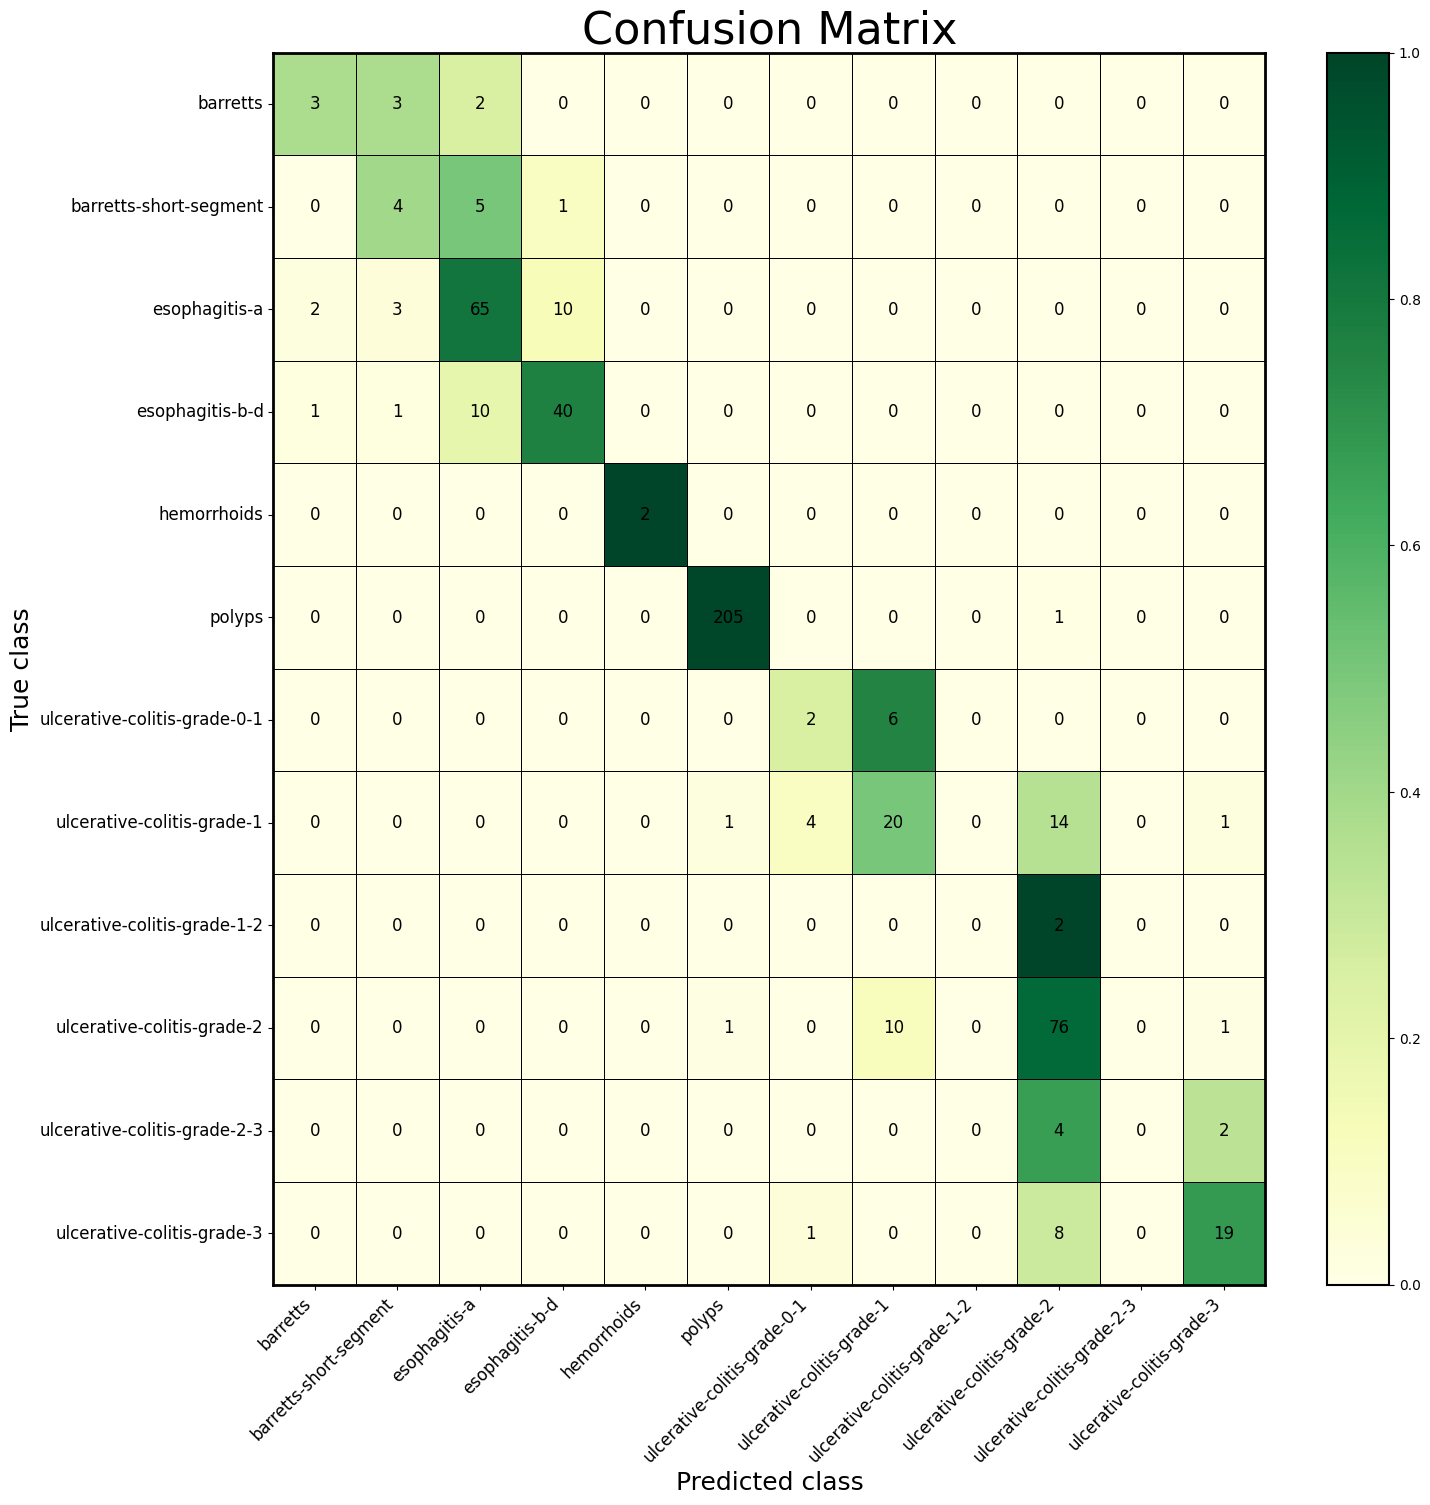

In [8]:
from sklearn.metrics import f1_score
from DLOlympus.training.plots import plot_confusion_matrix

preds = data['prediction'].values
truths = data['ground_truth'].values

results = {
    'accuracy': (preds == truths).mean(),
    'f1_score': f1_score(truths, preds, average='macro')}

_ = plot_confusion_matrix(truths, preds, np.unique(data.ground_truth.values), save_path)